In [1]:
import sys
sys.path.append('../')

In [2]:
from ax.plot.contour import plot_contour
from ax.plot.slice import plot_slice
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.metrics.branin import branin
from ax.utils.notebook.plotting import render, init_notebook_plotting
init_notebook_plotting()

[INFO 02-01 12:18:30] ax.utils.notebook.plotting: Injecting Plotly library into cell. Do not overwrite or delete cell.


In [3]:
from opal import Linac, Collider
from opal import SourceBasic, StageNonlinear1D, InterstageELEGANT, InterstageBasic, BeamDeliverySystemBasic, InteractionPointGUINEAPIG
from opal.utilities.plasmaphysics import beta_matched
import numpy as np

def target_function(params):
   
    Etarget = 80e9 # [eV]
    E0 = 3e9 # [eV]
    deltaE = (Etarget-E0)/params['Nstages']
    
    # define driver
    driver = SourceBasic()
    driver.Q = -5e-9 # [C]
    driver.E0 = deltaE*1.8 # [eV]
    driver.relsigE = 0.01
    driver.sigz = 20e-6 # [m]
    driver.z = 120e-6 # [m]
    driver.emitnx, driver.emitny = 10e-6, 10e-6 # [m rad]
    driver.betax, driver.betay = 30e-3, 30e-3 # [m]
    driver.Npart = 1000
    driver.wallplugEfficiency = 0.5
    #driver.jitter.t0 = 5e-15 # [s]
    #driver.jitter.x0, driver.jitter.y0 = 50e-9, 50e-9# [m]
    driver.acceleratingGradient = 25e6 # [V/m]

    # define stage
    stage = StageNonlinear1D()
    stage.driverSource = driver
    stage.deltaE = deltaE # [eV]
    stage.L = deltaE/5.5e9 # [m]
    stage.n0 = 2e22 # [m^-3]
    stage.reljitter.n0 = 0.01
    stage.enableBetatron = True

    # define beam
    source = SourceBasic()
    source.Q = -2.7e-9 # [C]
    source.E0 = E0 # [eV]
    source.relsigE = 0.005
    source.sigz = 12e-6 # [m]
    source.z = -60e-6 # [m]
    source.emitnx = 1e-6 # [m rad]
    source.emitny = 0.035e-6 # [m rad]
    source.betax = beta_matched(stage.n0, source.E0) # [m]
    source.betay = source.betax
    source.Npart = 200
    source.wallplugEfficiency = 0.1
    #source.jitter.t0 = 5e-15 # [s]
    #source.jitter.x0, source.jitter.y0 = 50e-9, 50e-9 # [m]
    source.acceleratingGradient = 25e6 # [V/m]

    # define interstage
    #interstage = InterstageELEGANT()
    interstage = InterstageBasic()
    interstage.beta0 = lambda E: beta_matched(stage.n0, E) # [T]
    interstage.Bdip = 0.5 # [T]
    interstage.Ldip = lambda E: 1 * np.sqrt(E/10e9) # [m(eV)]
    interstage.enableISR = True
    interstage.enableCSR = False

    # beam delivery system
    bds = BeamDeliverySystemBasic()
    bds.beta_waist_x = 8e-3 # [m]
    bds.beta_waist_y = 0.4e-3 # [m]
    #bds.L = 20 # [m]

    # define linac
    linac = Linac(source, stage, interstage, bds, Nstages = params['Nstages'], alternatingInterstagePolarity=False)

    # define interaction point
    ip = InteractionPointGUINEAPIG()

    # define collider
    collider = Collider(linac, ip)

    # track particles
    collider.run(shots=1, verbose=False)

    # plot evolution
    linac.plotEvolution(useStageNumbers=True)
    
    # return objective functions
    return collider.totalCost()

[INFO 02-01 12:18:31] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='Nstages', parameter_type=INT, range=[1, 15])], parameter_constraints=[]).
[INFO 02-01 12:18:31] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 02-01 12:18:31] ax.modelbridge.dispatch_utils: Calculating the number of remaining initialization trials based on num_initialization_trials=None max_initialization_trials=None num_tunable_parameters=1 num_trials=None use_batch_trials=False
[INFO 02-01 12:18:31] ax.modelbridge.dispatch_utils: calculated num_initialization_trials=5
[INFO 02-01 12:18:31] ax.modelbridge.dispatch_utils: num_completed_initialization_trials=0 num_remaining_initialization_trials=5
[INFO 02-01 12:18:31] ax.modelbridge.dispatch_utils: Using Bayesian Optimization generation strategy: GenerationStrategy(name='Sobol+GPEI', steps=[So

>> EVENT #1: Luminosity (full/peak/geom.): 2.5 / 0.66 / 2.2 μb^-1


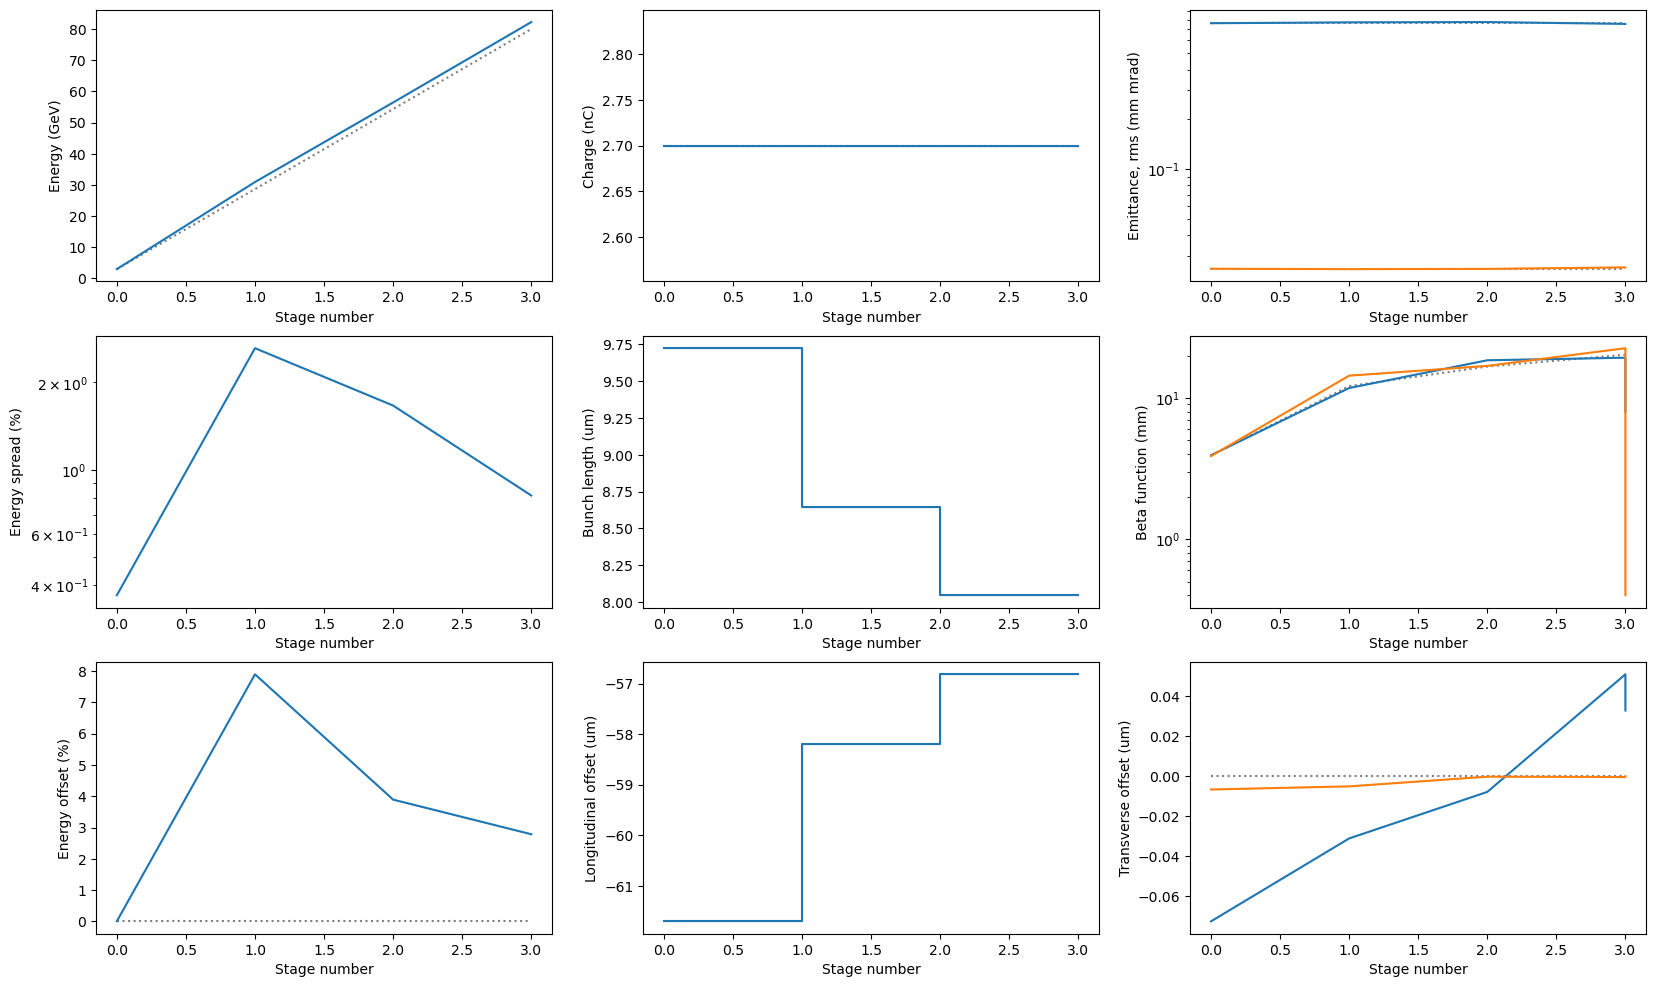

[INFO 02-01 12:18:40] ax.service.managed_loop: Running optimization trial 2...


>> EVENT #1: Luminosity (full/peak/geom.): 3.3 / 0.66 / 2.6 μb^-1


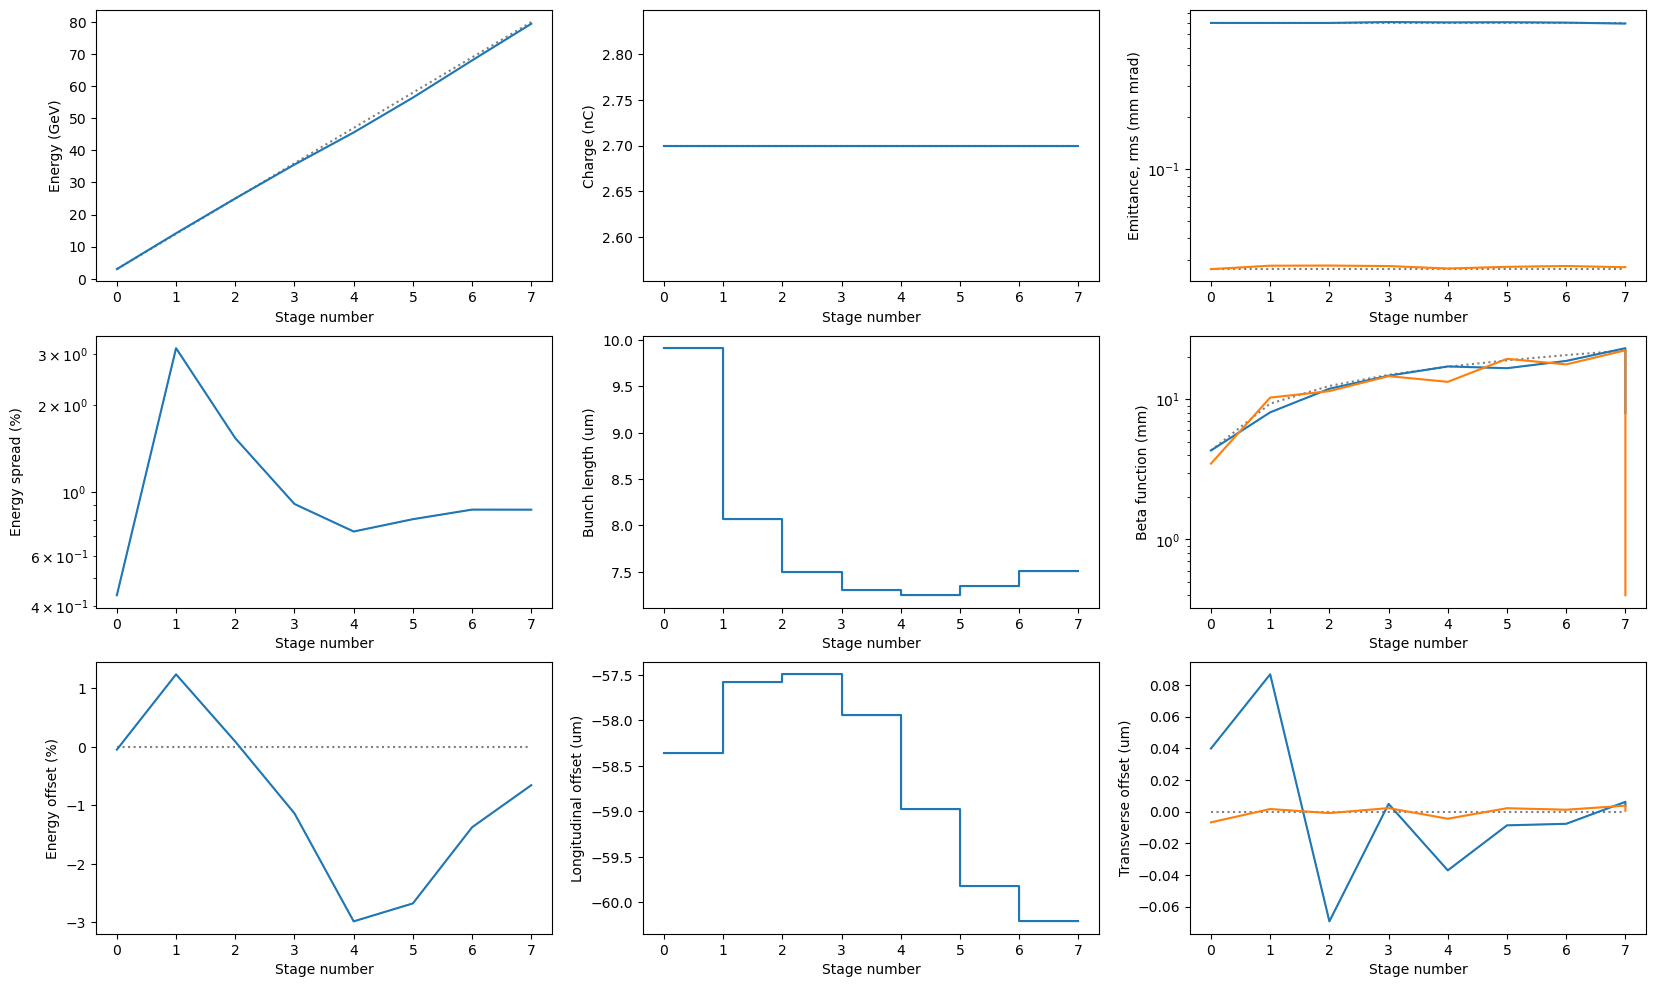

[INFO 02-01 12:19:02] ax.service.managed_loop: Running optimization trial 3...


>> EVENT #1: Luminosity (full/peak/geom.): 2.3 / 0.61 / 2.1 μb^-1


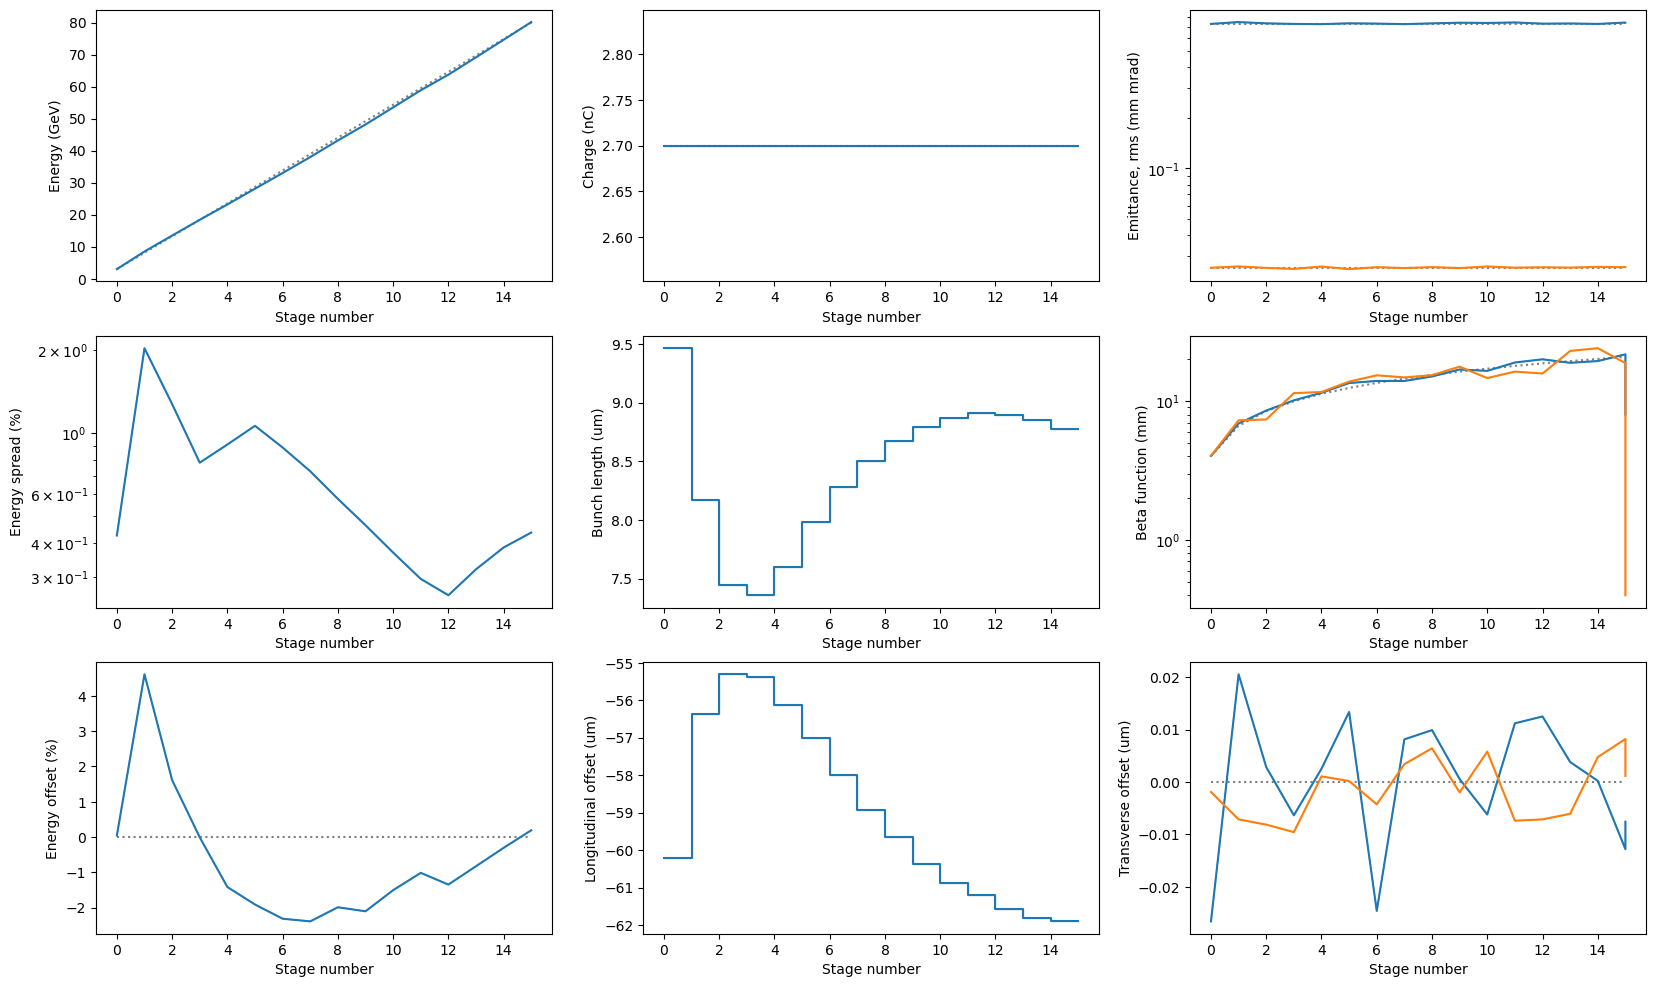

[INFO 02-01 12:19:44] ax.service.managed_loop: Running optimization trial 4...


>> EVENT #1: Luminosity (full/peak/geom.): 2.4 / 0.58 / 2.4 μb^-1


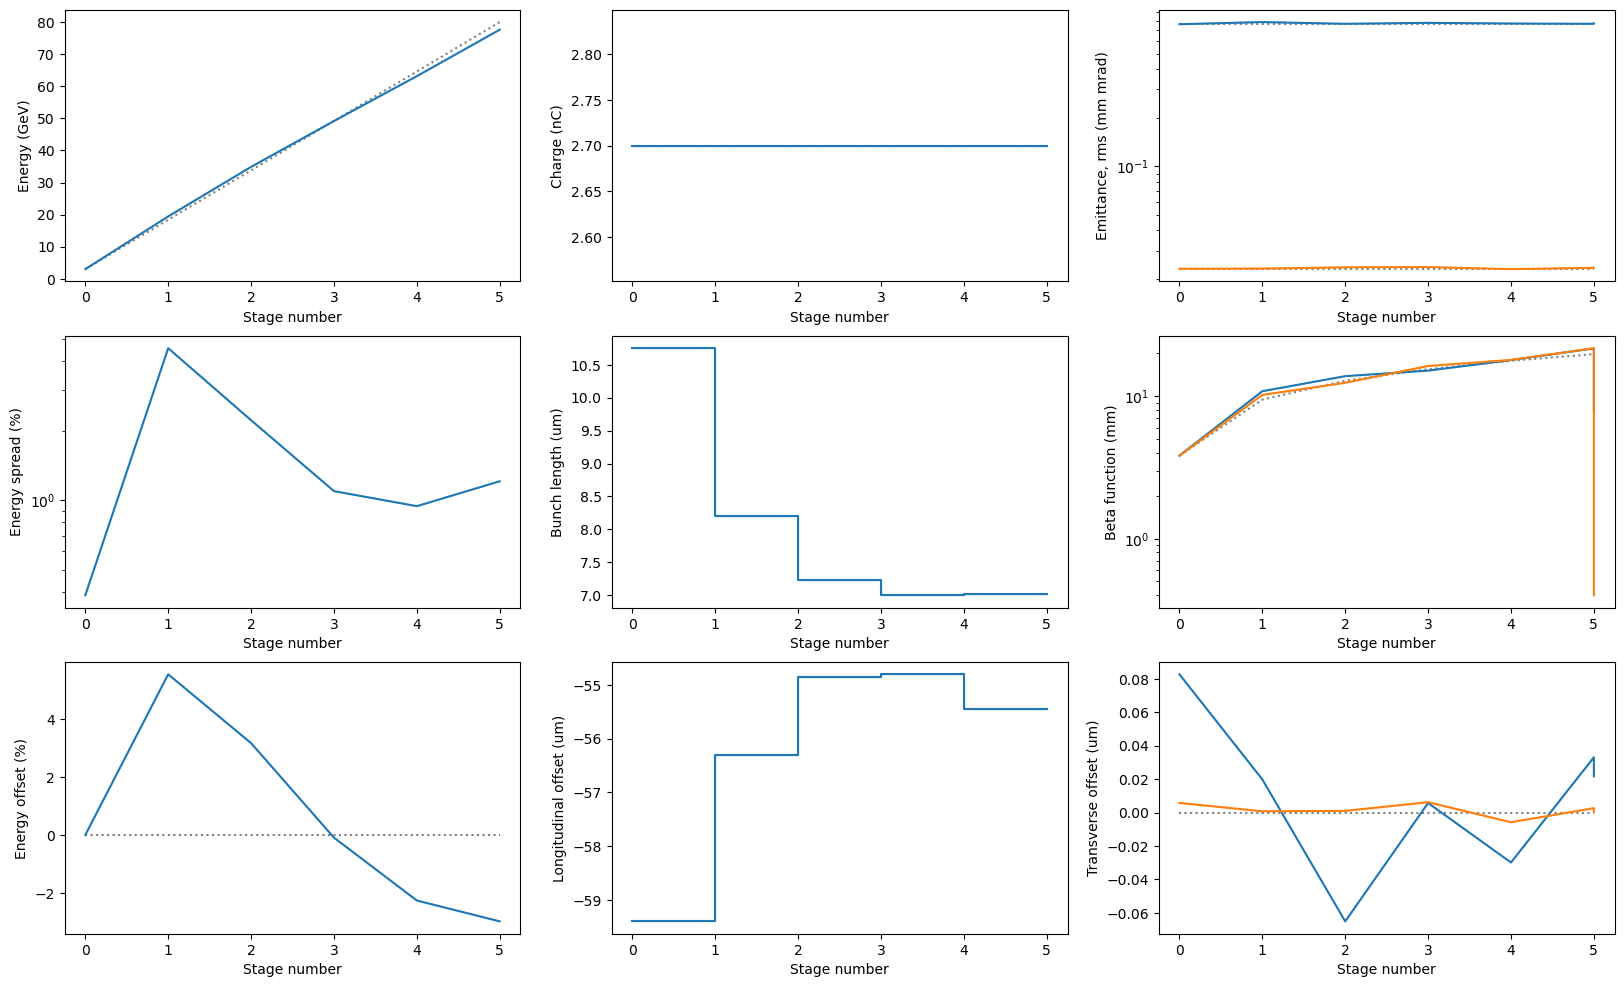

[INFO 02-01 12:20:00] ax.service.managed_loop: Running optimization trial 5...


>> EVENT #1: Luminosity (full/peak/geom.): 2.5 / 0.65 / 2.2 μb^-1


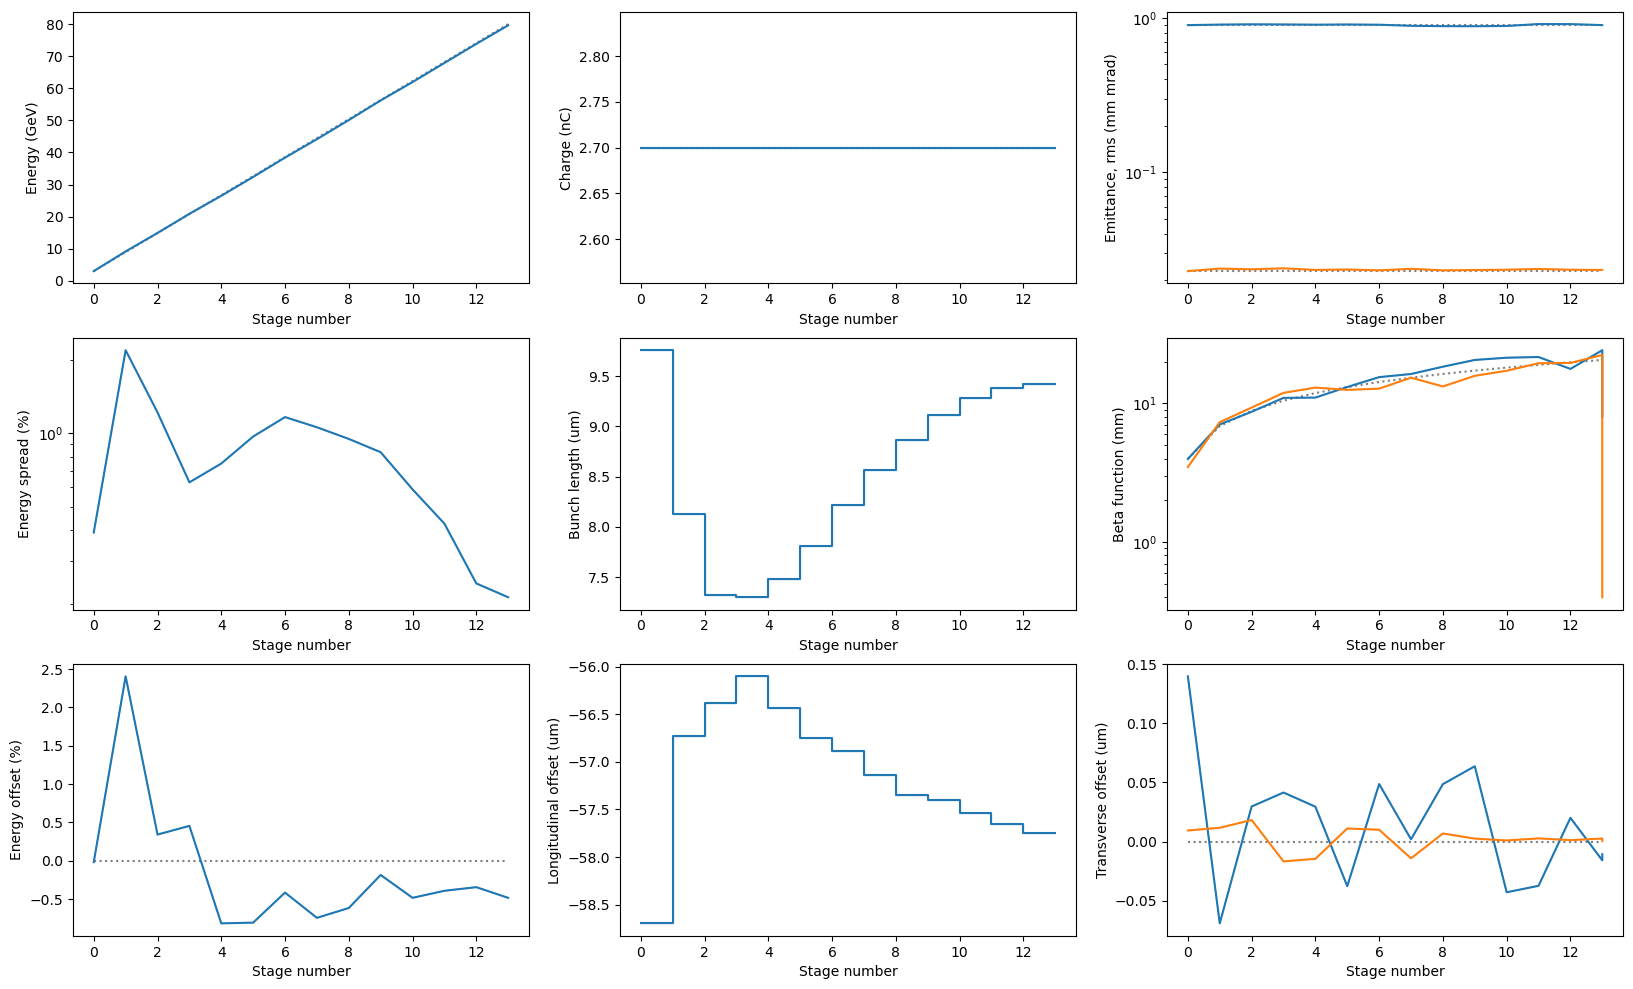

In [4]:
best_parameters, best_values, experiment, model = optimize(
        experiment_name="cheapcollider",
        objective_name="totalcost",
        evaluation_function=target_function,
        minimize=True,
        total_trials=5,
        parameters=[
          {
            "name": "Nstages",
            "type": "range",
            "bounds": [1, 15],
            "value_type": 'int'
          }
        ])

In [5]:
best_parameters

{'Nstages': 13}

In [6]:
render(plot_slice(model, "Nstages", "totalcost"))

NotImplementedError: RandomModelBridge does not support prediction.